In [65]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

## 1. Загрузка датасета и анализ признаков

In [272]:
DATA_ROOT = Path('./data/course_project/')
# MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_PATH = DATA_ROOT / 'test.csv'

# output
PREP_DATASET_PATH = DATA_ROOT / 'data_prep.csv'
TRAIN_PART_PATH = DATA_ROOT / 'train_part.csv'
TEST_PART_PATH = DATA_ROOT / 'test_part.csv'

In [273]:
df_base = pd.read_csv(DATASET_PATH)
df_base.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


Для обучения модели у нас 7500 наблюдений и 16 признаков.  Тестовый датасет включает 2500 наблюдений. Признаки есть и колличественные и качественные.

In [274]:
df_base.shape

(7500, 17)

In [275]:
df_base.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

Home Ownership - домовладение
Annual Income - годовой доход
Years in current job - количество лет на текущем месте работы
Tax Liens - налоговые обременения
Number of Open Accounts - количество открытых счетов
Years of Credit History - количество лет кредитной истории
Maximum Open Credit - наибольший открытый кредит
Number of Credit Problems - количество проблем с кредитом
Months since last delinquent - количество месяцев с последней просрочки платежа
Bankruptcies - банкротства
Purpose - цель кредита
Term - срок кредита
Current Loan Amount - текущая сумма кредита
Current Credit Balance - текущий кредитный баланс
Monthly Debt - ежемесячный долг
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [276]:
for cat_colname in df_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Так как Term включает всего 2 значения, его можно преобразовать до бинарного вида

In [277]:
df_base.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Есть много пропусков в признаке Months since last delinquent - количество месяцев с последней просрочки платежа (возможно, это значит что кредит никогда не был просрочен)
А так же в ~21% наблюдений пропущены значения Annual Income(годовой доход) и Credit Score. Так как число пропусков одинаковое, скорее всего пропуски в одних и тех же наблюдениях и Credit Score - это функция от годового дохода. Будем заменять на медианные значения, т.к. отказаться от этих важных признаков не можем.

In [163]:
df_base.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [164]:
df_base.loc[(df_base['Annual Income'].isna())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


<AxesSubplot:>

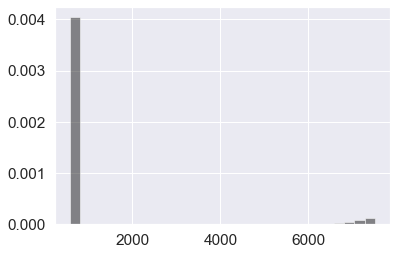

In [165]:
# признак Credit Score имеет как скопление наблюдений с низкими значениями и так и явно выраженное скопление значений 
# после значения = ~6000
plt.figure()
df_base["Credit Score"].hist(color='k', bins=30, density=True, label='class 1', alpha=0.5)

In [166]:
#Визуально как будто все наблюдения с Credit Score >6000 имеют просрочку по кредиту Credit Default = 1
df_base.loc[(df_base['Credit Score']>6000)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


In [167]:
# Удостоверяемся, что данный признак важен и все наблюдения с Credit Score >6000 имеют просрочку по кредиту
# либо это ошибочные данные, либо какие-то специальные обозначения для признака
high_crefit_score = pd.DataFrame(df_base.loc[(df_base['Credit Score']>6000)])
high_crefit_score['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

Text(0.5, 0, 'Credit Score')

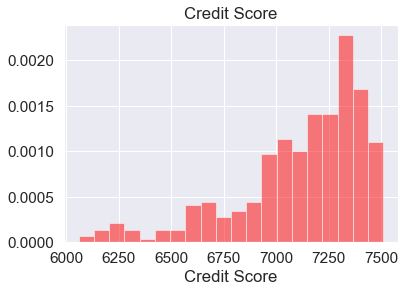

In [168]:
df_class0 = high_crefit_score[high_crefit_score['Credit Default'] == 0]
df_class1 = high_crefit_score[high_crefit_score['Credit Default'] == 1]

fig, ax = plt.subplots()
#ax1, ax2 = ax.flatten()


df_class0.hist(ax=ax, column='Credit Score', bins=20, density=True, alpha=0.5, color="Grey")
df_class1.hist(ax=ax, column='Credit Score', bins=20, density=True, alpha=0.5, color="Red")

ax.set_xlabel('Credit Score')

In [169]:
#Визуально удостоверимся, что наблюдения с очень высоким уровнем дохода не ошибочны
df_base.loc[(df_base['Annual Income']>8000000)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1025,Rent,8923844.0,3 years,0.0,15.0,17.2,1452000.0,0.0,NaN,0.0,debt consolidation,Short Term,670428.0,1084710.0,62095.0,723.0,0
1984,Home Mortgage,8758449.0,10+ years,0.0,10.0,20.6,0.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,2759503.0,12919.0,748.0,0
2200,Rent,9338880.0,10+ years,0.0,7.0,7.3,1092608.0,0.0,NaN,0.0,business loan,Short Term,788480.0,326496.0,40546.0,720.0,0
2474,Home Mortgage,8633790.0,2 years,0.0,13.0,15.6,1091200.0,0.0,36.0,0.0,debt consolidation,Long Term,777546.0,765244.0,25038.0,679.0,0
4491,Home Mortgage,8200229.0,2 years,0.0,11.0,16.7,333630.0,0.0,29.0,0.0,debt consolidation,Short Term,117040.0,116128.0,8610.0,7440.0,1
5396,Home Mortgage,8710740.0,2 years,2.0,15.0,16.5,3162896.0,2.0,NaN,0.0,debt consolidation,Short Term,560340.0,1663545.0,40215.0,735.0,1
6472,Rent,10149344.0,5 years,0.0,10.0,17.5,270380.0,0.0,22.0,0.0,debt consolidation,Short Term,664818.0,205713.0,61235.0,692.0,0


In [170]:
# Всего 18 наблюдений с кол-вом месяцев с последней просрочки платежа равным нолю, поэтому можно считать, 
# что пропущенные значения в Months since last delinquent - это никогда не просрачиваемые наблюдения/кредиты
df_base.loc[(df_base['Months since last delinquent']==0)].shape[0]

18

### В итоге обработку датасета можно представить как:

In [278]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.modes = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан и мод
        self.medians = df.median()
        self.modes = df.mode()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски и выбросы
        
        #   Months since last delinquent     
        # предполагаем, что пропуски этого признака означают непросроченный кредит, заменяем пропуски на ноль 
        # и добавляем признак непросроченного кредита
        df['nan_delinquent'] = 0
        nan_delinquent = df['Months since last delinquent'].isna()
        
        df.loc[nan_delinquent, 'nan_delinquent'] = 1
        df.loc[nan_delinquent, 'Months since last delinquent'] = 0        
 
      
        # Annual Income - пропуски заменяем на медианное значение
        df['nan_income'] = 0
        nan_income = df['Annual Income'].isna() 
                                          
        df.loc[nan_income, 'nan_income'] = 1
        df.loc[nan_income, 'Annual Income'] = self.medians['Annual Income'] 
        
        
        # Credit Score - пропуски заменяем на медианное значение 
        df['nan_creditscore'] = 0
        nan_creditscore = df['Credit Score'].isna() 
                                          
        df.loc[nan_creditscore, 'nan_creditscore'] = 1
        df.loc[nan_creditscore, 'Credit Score'] = self.medians['Credit Score'] 
        
        
        # Current Loan Amount 
        # почти 1 тыс. значений 99999999 и vожно предположить, что это что-то вроде открытой кредитной линии. 
        # Можно заменить на медиану и добавить признак
        df['opened_loan'] = 0
        opened_loan = df['Current Loan Amount']==99999999
                                          
        df.loc[opened_loan, 'opened_loan'] = 1
        df.loc[opened_loan, 'Current Loan Amount'] = self.medians['Current Loan Amount'] 
        
        # Bankruptcies 
        # предполагаем, что пропуски в этом поле означают отсутствие банкротств в кред. истории.
        df['nan_bankrupt'] = 0
        nan_bankrupt = df['Bankruptcies'].isna()
                                          
        df.loc[nan_bankrupt, 'nan_bankrupt'] = 1
        df.loc[nan_bankrupt, 'Bankruptcies'] = 0
        
        # Years in current job
        # пропуски заменяем на самое большое по числу вхождений значение (это 10+ лет)
        
        df['nan_jobyears'] = 0
        nan_jobyears = df['Years in current job'].isna()
        df.loc[nan_jobyears, 'nan_jobyears'] = 1
        df.loc[nan_jobyears, 'Years in current job'] = self.modes['Years in current job'][0]    
        
        return df

In [279]:
class FeatureGenetator():
        
    def __init__(self):
        
        self.med_loan_by_purpose = None
        self.med_loan_by_credithistory = None
        
        self.med_loan_by_purpose_median = None
        self.med_loan_by_credithistory_median = None        

        
    def fit(self, X, y=None):
        
         #loanSizeByPurpose
            
        df = X.copy()
        
        if y is not None:
            df['Current Loan Amount'] = y.values
            
        self.med_loan_by_purpose = df.groupby(['Purpose']).agg({'Current Loan Amount':'median'}).\
                                        rename(columns={'Current Loan Amount':'MedLoanByPurpose'}) 
        
        self.med_loan_by_purpose_median = self.med_loan_by_purpose['MedLoanByPurpose'].median()
        
        
        if y is not None:
            df['Current Loan Amount'] = y.values
            
        df['rounded_years'] = round(df['Years of Credit History'])    
        self.med_loan_by_credithistory = df.groupby(['rounded_years']).agg({'Current Loan Amount':'median'}).\
                                        rename(columns={'Current Loan Amount':'MedLoanByCredHistory'}) 
        
        self.med_loan_by_credithistory_median = self.med_loan_by_credithistory['MedLoanByCredHistory'].median()
            
    def transform(self, df):                                              
                                              
        #Term - перевод в бинарный тип
        
        binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
        df['Term'] = df['Term'].replace(binary_to_numbers)
        
        # Credit Score >6000 - максимальная вероятность просрочки, выделяем в отдельный признак
        df['max_credscore'] = 0
        df.loc[df['Credit Score'] > 6000, 'max_credscore'] = 1 


        # Years in current job - перевод в порядковые числа
        df['num_jobyears'] = 0

        df.loc[df['Years in current job'] == '< 1 year', 'num_jobyears'] = 0
        df.loc[df['Years in current job'] == '1 year', 'num_jobyears'] = 1
        df.loc[df['Years in current job'] == '2 years', 'num_jobyears'] = 2
        df.loc[df['Years in current job'] == '3 years', 'num_jobyears'] = 3
        df.loc[df['Years in current job'] == '4 years', 'num_jobyears'] = 4
        df.loc[df['Years in current job'] == '5 years', 'num_jobyears'] = 5
        df.loc[df['Years in current job'] == '6 years', 'num_jobyears'] = 6
        df.loc[df['Years in current job'] == '7 years', 'num_jobyears'] = 7
        df.loc[df['Years in current job'] == '8 years', 'num_jobyears'] = 8
        df.loc[df['Years in current job'] == '9 years', 'num_jobyears'] = 9
        df.loc[df['Years in current job'] == '10+ years', 'num_jobyears'] = 10
        
        
        #Генерация нового признака - дельта между ежемес. доходом и ежемес. платежом по кредиту
        df['IncomeDebtDif'] = df['Annual Income'] / 12 - df['Monthly Debt'] 
        
        #Генерация новых признаков - отношение между ежемес. платежом по кредиту и общей суммой кредита
        # и отношения между текущим кред.балансом и общей суммой кредита
        
        try: 
            df['CreditPerc'] = df['Monthly Debt'] / df['Current Loan Amount']       
            df['CoveredCredit'] = df['Current Credit Balance'] / df['Current Loan Amount'] 
        
        except ValueError:
            df['CreditPerc'] = 0
            df['CoveredCredit'] = 0
            
        
        #Feature encoding - средняя величина займа в зависимости от цели кредита
        if self.med_loan_by_purpose is not None:
            df = df.merge(self.med_loan_by_purpose, on=['Purpose'], how='left')   
            
        #Feature encoding - средняя величина займа в зависимости от кол-ва лет кредитной истории
        
        df['rounded_years'] = round(df['Years of Credit History'])
        if self.med_loan_by_credithistory is not None:
            df = df.merge(self.med_loan_by_credithistory, on=['rounded_years'], how='left') 
            
        df['MedLoanByCredHistory'].fillna(self.med_loan_by_credithistory_median, inplace=True)
        
        
        #Преобразование в дамми столбцы категориальной переменной purpose
        dummy_purpose = pd.get_dummies(df['Purpose'])
        df = pd.concat([df, dummy_purpose], axis=1)
        
        #Преобразование в дамми столбцы категориальной переменной Home Ownership
        df["Home Ownership"].replace({"Have Mortgage": "Home Mortgage"}, inplace=True)
        dummy_homeOwn = pd.get_dummies(df['Home Ownership'])
        df = pd.concat([df, dummy_homeOwn], axis=1)
                                             
                                              
        return df

In [280]:
pipe = DataPipeline()
pipe.fit(df_base)
df_base = pipe.transform(df_base)

features_gen = FeatureGenetator()
features_gen.fit(df_base)
df_base = features_gen.transform(df_base)

In [281]:
df_fin_test = pd.read_csv(TEST_PATH)
df_fin_test = pipe.transform(df_fin_test)
df_fin_test = features_gen.transform(df_fin_test)
df_fin_test = df_fin_test.fillna(0)

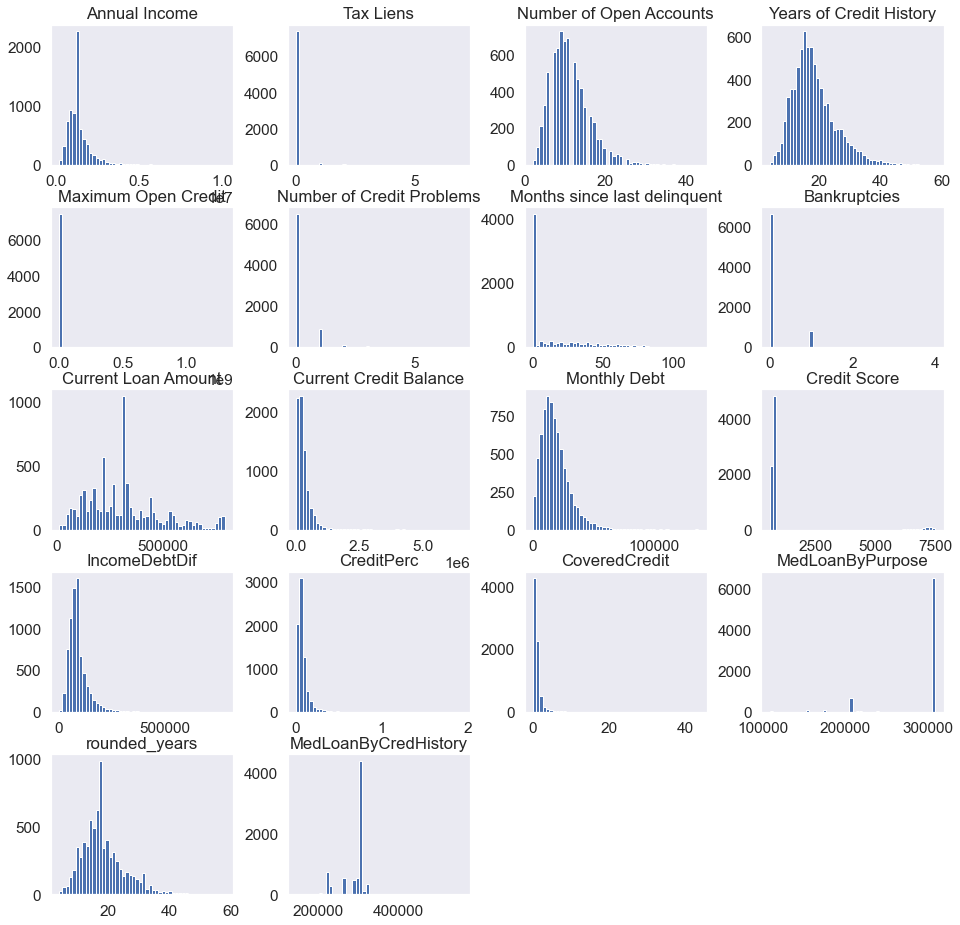

In [175]:
df_num_features = df_base.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32'])
df_num_features.hist(figsize=(16,16), bins=50, grid=False);

In [176]:
df_base.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,nan_delinquent,nan_income,nan_creditscore,opened_loan,nan_bankrupt,nan_jobyears,max_credscore,num_jobyears,IncomeDebtDif,CreditPerc,CoveredCredit,MedLoanByPurpose,rounded_years,MedLoanByCredHistory,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,0,309573.0,47386.0,7914.0,749.0,0,1,0,0,1,0,1,0,10,32259.916667,0.025564,0.153069,309573.0,26.0,323389.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,1,264968.0,394972.0,18373.0,737.0,1,1,0,0,0,0,0,0,10,67084.250000,0.069340,1.490640,309573.0,15.0,309573.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,0,309573.0,308389.0,13651.0,742.0,0,1,0,0,1,0,0,0,8,48966.666667,0.044096,0.996175,309573.0,35.0,263219.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,0,121396.0,95855.0,11338.0,694.0,0,1,0,0,0,0,0,0,6,55751.000000,0.093397,0.789606,309573.0,22.0,309573.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,0,125840.0,93309.0,7180.0,719.0,0,1,0,0,0,0,0,0,8,57508.666667,0.057057,0.741489,309573.0,14.0,301147.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,1,337304.0,165680.0,18692.0,731.0,1,1,1,1,0,0,0,0,7,78673.500000,0.055416,0.491189,206272.0,15.0,309573.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,0,309573.0,51623.0,2317.0,745.0,0,0,0,0,1,0,0,0,10,123608.666667,0.007485,0.166755,309573.0,20.0,309573.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,0,250888.0,89015.0,19761.0,705.0,1,0,0,0,0,0,0,0,10,66910.666667,0.078764,0.354800,206272.0,12.0,264858.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,0,129734.0,19.0,17.0,731.0,0,1,1,1,0,0,0,0,5,97348.500000,0.000131,0.000146,309573.0,16.0,307934.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,1,572880.0,205333.0,17613.0,731.0,1,0,1,1,0,0,0,0,1,79752.500000,0.030745,0.358422,309573.0,25.0,309573.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [177]:
# Проверяем, что все пропуски обработаны
df_base.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
nan_delinquent                  0
nan_income                      0
nan_creditscore                 0
opened_loan                     0
nan_bankrupt                    0
nan_jobyears                    0
max_credscore                   0
num_jobyears                    0
IncomeDebtDif                   0
CreditPerc                      0
CoveredCredit                   0
MedLoanByPurpose                0
rounded_years 

In [178]:
df_fin_test.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
nan_delinquent                  0
nan_income                      0
nan_creditscore                 0
opened_loan                     0
nan_bankrupt                    0
nan_jobyears                    0
max_credscore                   0
num_jobyears                    0
IncomeDebtDif                   0
CreditPerc                      0
CoveredCredit                   0
MedLoanByPurpose                0
rounded_years                   0
MedLoanByCredH

## 2. Оценка корреляций признаков между собой и с целевой переменной

In [282]:
TARGET_NAME = 'Credit Default'
# Коррелированные переменные или получившиеся дубликаты переменных убираем (их было видно по матрице корреляций или их наличие снижало качество модели)
CORRELATED_NAMES = ['rounded_years', 'nan_creditscore', 'Years in current job', 'MedLoanByPurpose', 
                   'Bankruptcies', 'nan_bankrupt', 'take a trip', 'vacation', 'wedding',  'medical bills', 'buy house',
                   'renewable energy']

BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME]).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 
                     'Term', 'IncomeDebtDif', 'CreditPerc', 'CoveredCredit', 'MedLoanByPurpose', 'MedLoanByCredHistory', 
                    'nan_bankrupt', 'nan_jobyears', 'num_jobyears', 'nan_delinquent', 'nan_income', 'opened_loan', 
                     'max_credscore', 
                    'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 
                     'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'renewable energy', 
                     'small business', 'take a trip', 'vacation', 'wedding', 
                     'Home Mortgage', 'Own Home', 'Rent']

DUMMY_FEATURES = ['business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 
                     'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'renewable energy', 
                     'small business', 'take a trip', 'vacation', 'wedding', 
                     'Home Mortgage', 'Own Home', 'Rent']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose']


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

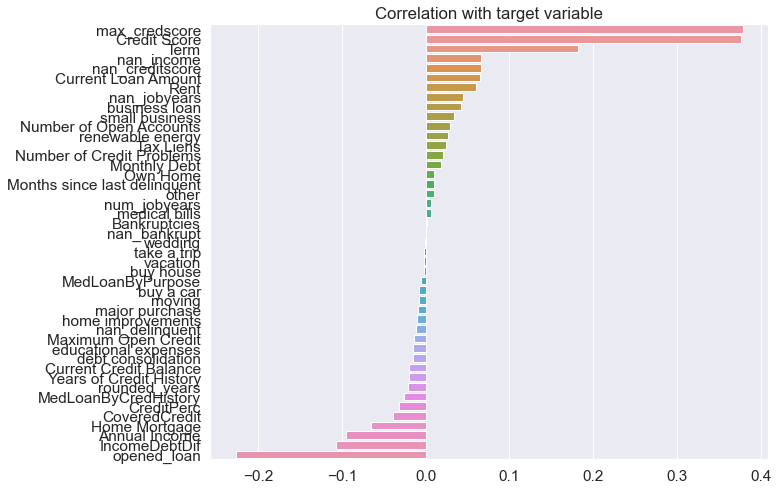

In [283]:
corr_with_target = df_base[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Если в целевой переменной 0 - погашен вовремя, 1 - просрочка, то имеют смысл следующие корреляции (линейные зависимости):
1) Term - вероятность просрочки больше у долгосрочных кредитов (признак = 1)
2) opened_loan - у клиентов с открытой кред. линией (opened_loan=1 т.е. Current Loan Amount=9999999) вероятность просрочки меньше. Возможно такие кредиты одобряют только платежеспособным и проверенным заемщикам.
3) Annual Income - логичная закономерность, что вероятность просрочки меньше у клиентов с бОльшим годовым доходом

Наоборот странная зависимость в признаках:
4) Чем выше Credit Score, тем выше вероятность просрочки (должно быть наоборот). Как установили выше кред. рейтинг > 6000 как будто означает дефолт по кредиту

Даже после преобразования категориального признака в числовой num_jobyears (число лет на текущем месте работы), данный признак не сильно коррелирует с целевой переменной.
Остальные новые фичи 'IncomeDebtDif', 'CreditPerc', 'CoveredCredit' могут иметь шанс на место в модели и лучше объяснить зависимую переменную. Max_crediscore - очень полезный, но подозрительный признак (где кред. рейтинг > 6000), наблюдения с таким рейтингом с большой вероятностью имеют просрочку

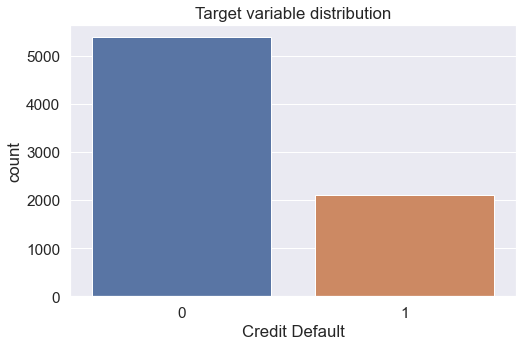

In [242]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_base)

plt.title('Target variable distribution')
plt.show()

In [243]:
#Есть дисбаланс классов
disbalance = df_base[TARGET_NAME].value_counts()[0] / df_base[TARGET_NAME].value_counts()[1]
disbalance

2.549455750118315

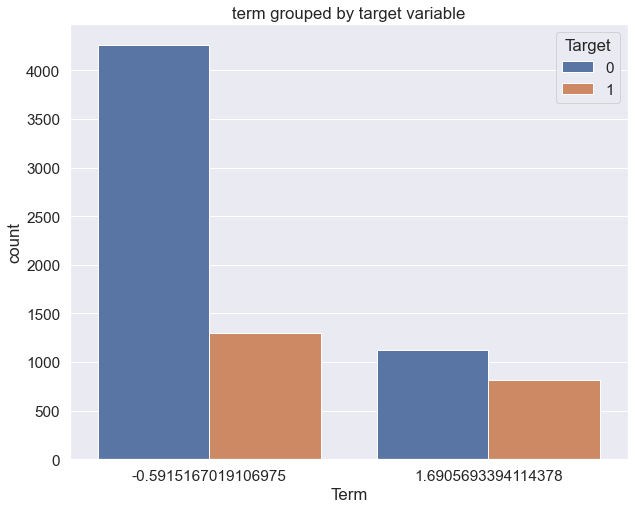

In [244]:
#Оценка признаков, наиболее коррелирующих с целевой переменной - нельзя быть уверенным в зависимости из-за дисбаланса классов
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET_NAME, data=df_base)
plt.title('term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

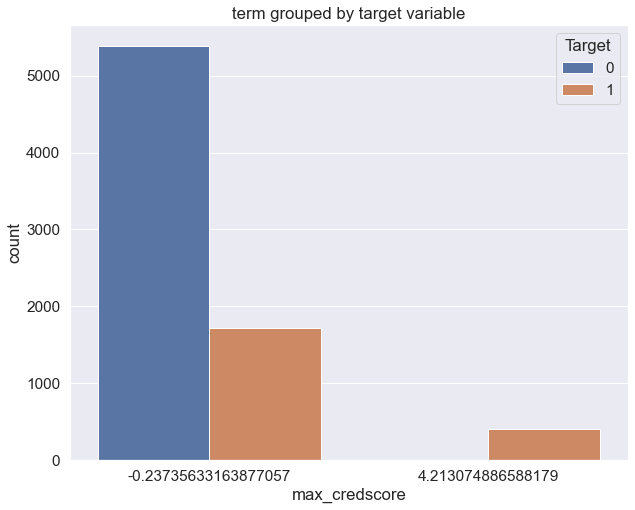

In [245]:
#наблюдения где кред. рейтинг > 6000 подтверждают большую вероятность просрочки
plt.figure(figsize=(10, 8))

sns.countplot(x="max_credscore", hue=TARGET_NAME, data=df_base)
plt.title('term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

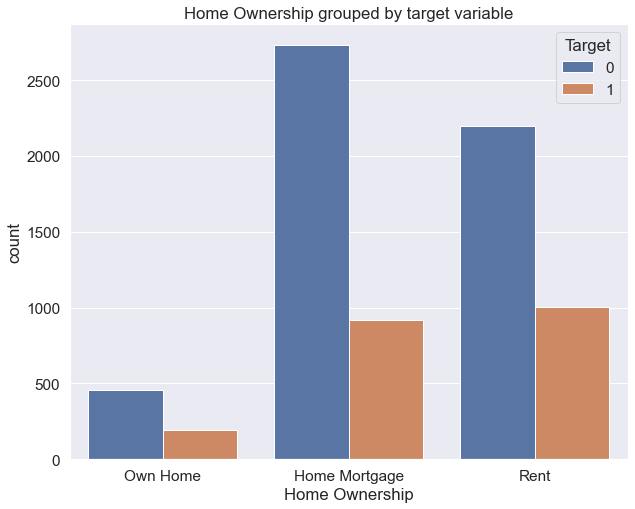

In [246]:
#Оценка категориальных признаков - примерно одинаковое соотношение классов зависимой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df_base)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

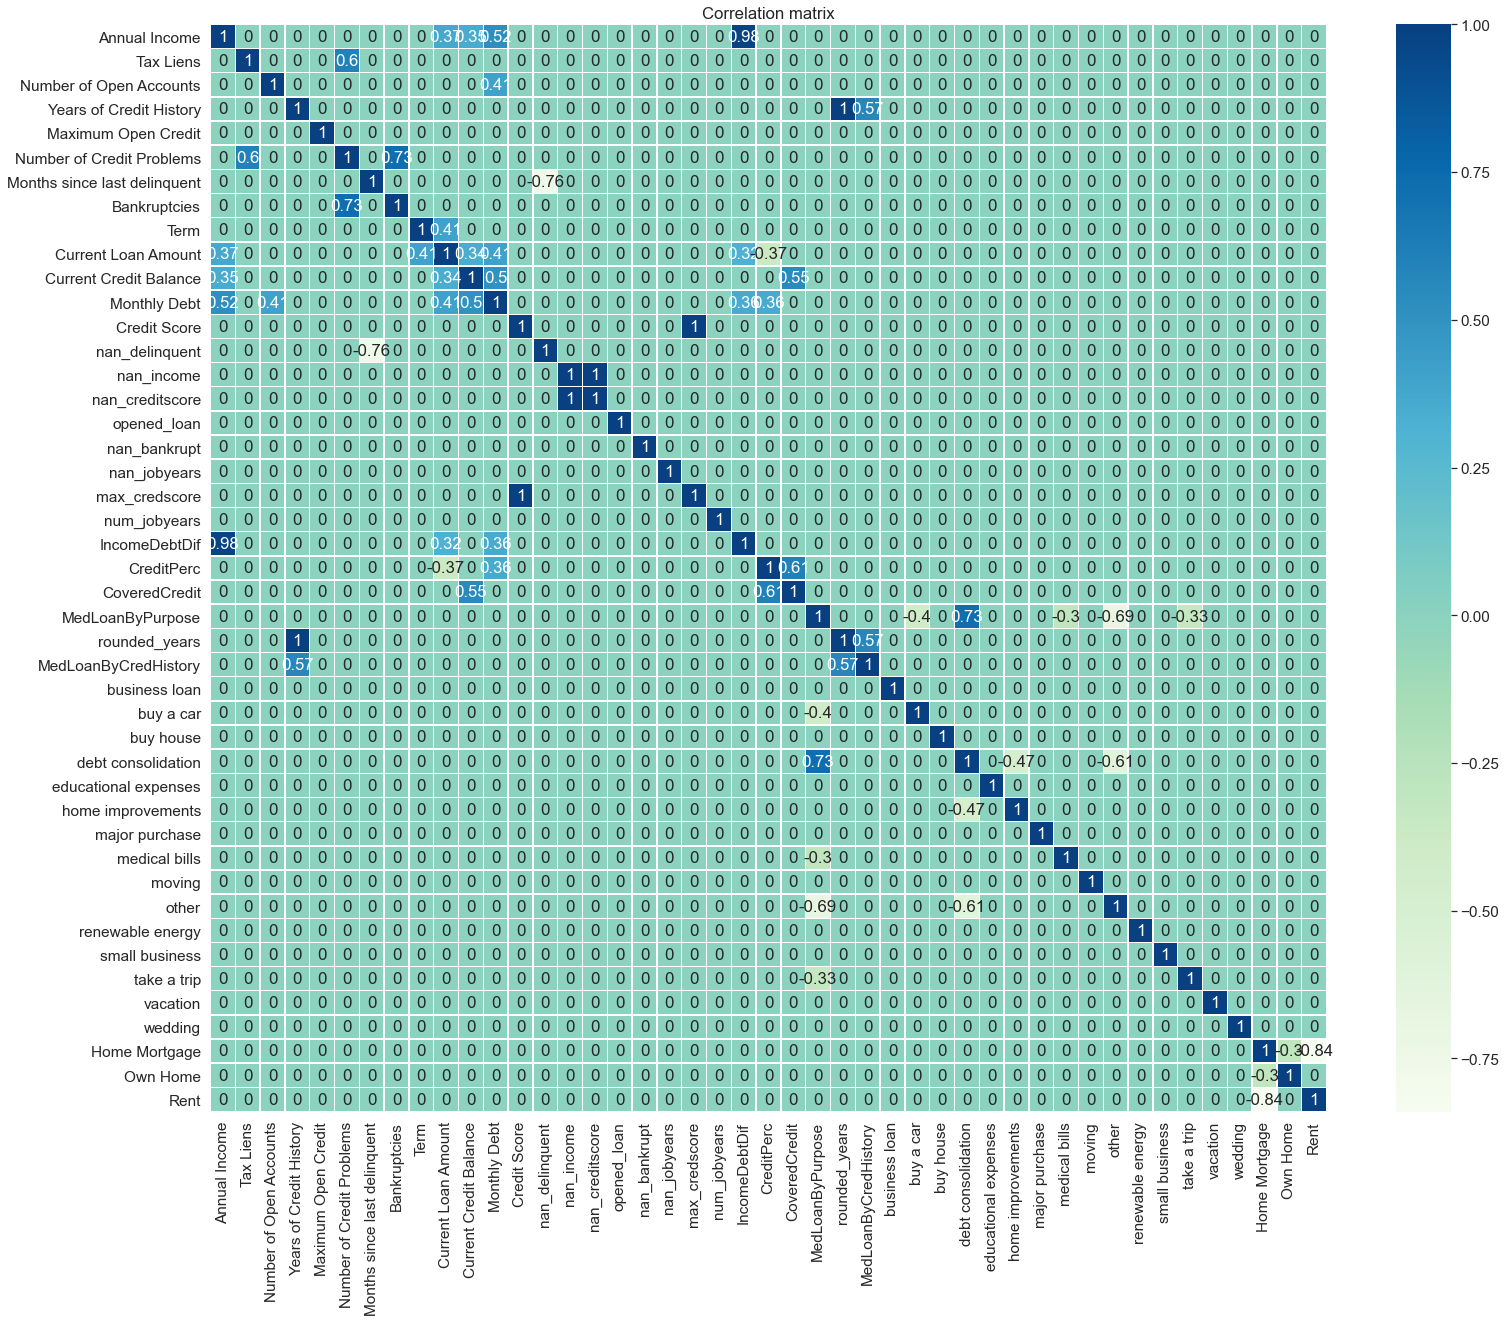

In [152]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df_base[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [182]:
# Добавляем необходимые фунции
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [183]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [184]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

### Нормализация переменных, разбиение на train и test, балансировка и построение базовых моделей

In [284]:
scaler = StandardScaler()

df_norm = df_base.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_base = df_norm.copy()

In [312]:
X = df_base[BASE_FEATURE_NAMES]
y = df_base[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [313]:
# Сохраняем предобработанные данные
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#df_base.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
#df_train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
#df_test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [314]:
# Для оценки моделей не Catboost исключаем категориальные переменные, в бинарные признаки они не были переведены
# из-за неявной зависимости с целевой переменной и большого числа категорий (добавилось бы много столбцов)

X = df_base.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES + CORRELATED_NAMES)
y = df_base[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES + CORRELATED_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES + CORRELATED_NAMES)
y_test = df_test[TARGET_NAME]

In [315]:
# Делаем балансировку методом SMOTE 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_sample(X_train, y_train)

y_train_balanced.value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

### Логистическая регрессия

In [316]:
model_lr = LogisticRegression()
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      3771
           1       0.71      0.66      0.68      3771

    accuracy                           0.70      7542
   macro avg       0.70      0.70      0.70      7542
weighted avg       0.70      0.70      0.70      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1616
           1       0.46      0.62      0.53       634

    accuracy                           0.69      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.73      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1157  459
1                239  395


### k ближайших соседей

In [317]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_knn, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      3771
           1       0.79      0.95      0.86      3771

    accuracy                           0.85      7542
   macro avg       0.86      0.85      0.85      7542
weighted avg       0.86      0.85      0.85      7542

TEST

              precision    recall  f1-score   support

           0       0.80      0.63      0.70      1616
           1       0.38      0.59      0.46       634

    accuracy                           0.62      2250
   macro avg       0.59      0.61      0.58      2250
weighted avg       0.68      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1014  602
1                261  373


### Дерево решений

In [318]:
model_tree = DecisionTreeClassifier(random_state=42,
                                    max_depth=6
                                    
                                    )
model_tree.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_tree, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      3771
           1       0.65      0.86      0.74      3771

    accuracy                           0.70      7542
   macro avg       0.72      0.70      0.69      7542
weighted avg       0.72      0.70      0.69      7542

TEST

              precision    recall  f1-score   support

           0       0.86      0.53      0.65      1616
           1       0.39      0.79      0.53       634

    accuracy                           0.60      2250
   macro avg       0.63      0.66      0.59      2250
weighted avg       0.73      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               851  765
1               136  498


### LightGBM

In [319]:
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:2.6},
                                 max_depth=1,
                                 n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)
evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      3771
           1       0.50      0.63      0.56      1479

    accuracy                           0.72      5250
   macro avg       0.67      0.69      0.67      5250
weighted avg       0.74      0.72      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1616
           1       0.47      0.60      0.53       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1190  426
1                255  379


### XGBoost

In [320]:
# Сильно переобучается, нужно подбирать параметры/размер выборки/исключать ненужные признаки
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1,
                              reg_lambda=1
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      3771
           1       0.75      0.75      0.75      3771

    accuracy                           0.75      7542
   macro avg       0.75      0.75      0.75      7542
weighted avg       0.75      0.75      0.75      7542

TEST

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1616
           1       0.46      0.60      0.52       634

    accuracy                           0.69      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1167  449
1                255  379


### CatBoost

In [321]:
#Для данной модели используем уже все признаки в т.ч. не только числовые

X_catb = df_base.drop(columns=[TARGET_NAME] + CORRELATED_NAMES)
y_catb = df_base[TARGET_NAME]

X_train_catb = df_train.drop(columns=[TARGET_NAME] + CORRELATED_NAMES)
y_train_catb = df_train[TARGET_NAME]

X_test_catb = df_test.drop(columns=[TARGET_NAME] + CORRELATED_NAMES)
y_test_catb = df_test[TARGET_NAME]

In [322]:
#Делаем балансировку методом oversampling 
df_for_balancing_catb = pd.concat([X_train_catb, y_train_catb], axis=1)
df_balanced_catb = balance_df_by_target(df_for_balancing_catb, TARGET_NAME, method='over')
   
df_balanced_catb[TARGET_NAME].value_counts()
X_train_balanced_catb = df_balanced_catb.drop(columns=TARGET_NAME)
y_train_balanced_catb = df_balanced_catb[TARGET_NAME]
y_train_balanced_catb.value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [323]:
#Качество базовой модели Catboost получилось чуть лучше, чем у остальных моделей
# f1-score по целевой переменной на тесте = 0,53 (как в xgb и логистической регрессии) 
# но общее средневзвешенное качество предсказания получилось выше у Catboost, модель не переобучилась (f1 score на тесте не хуже)

frozen_params = {
     #'class_weights':[1, disbalance], 
     'silent':True,
     'learning_rate':0.5,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':30,
     'boosting_type':'Ordered'
}

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5)
model_catb.fit(X_train_balanced_catb, y_train_balanced_catb, plot=True, eval_set=(X_test_catb, y_test_catb))

evaluate_preds(model_catb, X_train_balanced_catb, X_test_catb, y_train_balanced_catb, y_test_catb)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3771
           1       0.76      0.61      0.68      2958

    accuracy                           0.74      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1616
           1       0.52      0.54      0.53       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1304  312
1                294  340


### Важность признаков и подбор оптимального размера выборки

In [324]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

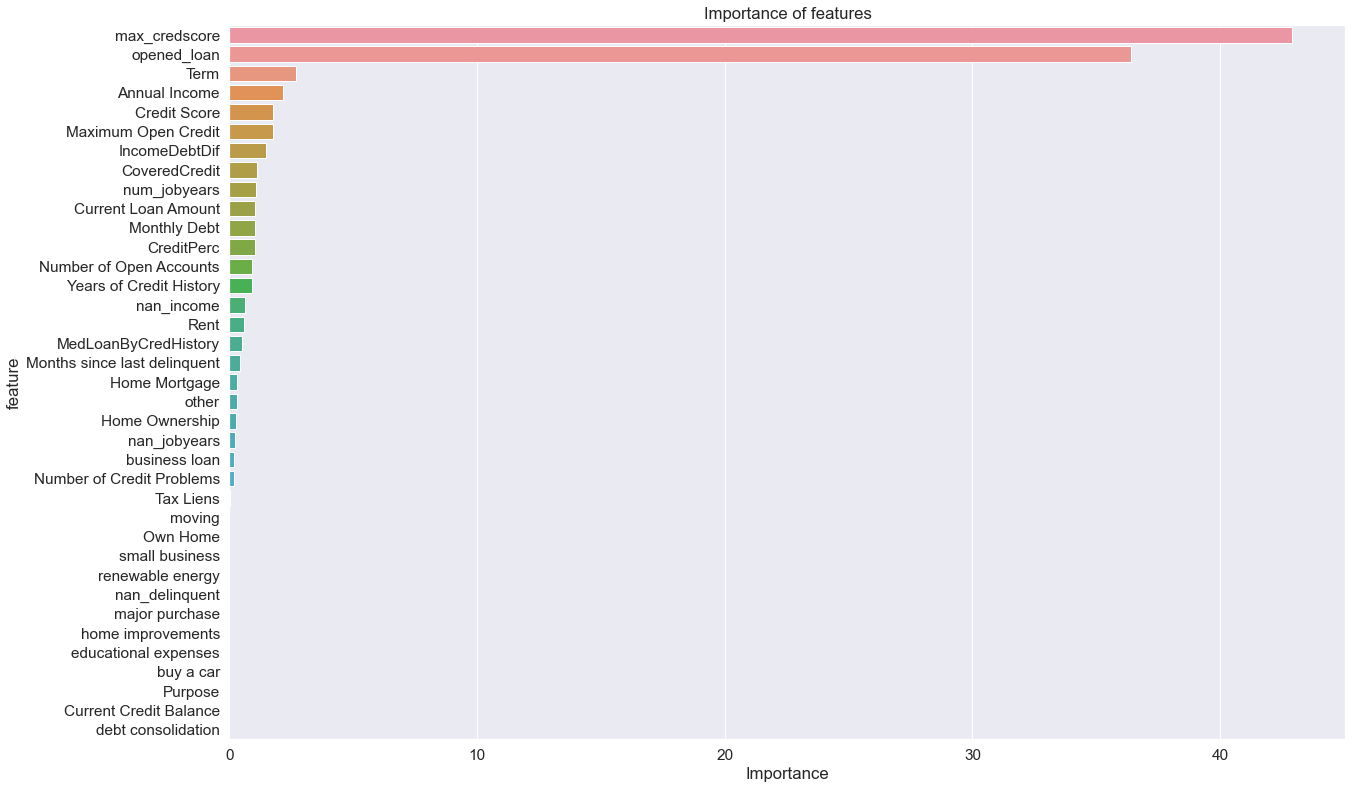

In [329]:
# В модели catboost целевую переменную лучше всего описывают первые 24 признака. 
important_features_top = show_feature_importances(X_train_balanced_catb.columns,
                                                  model_catb.feature_importances_, get_top=24)

In [330]:
important_features_top

['max_credscore',
 'opened_loan',
 'Term',
 'Annual Income',
 'Credit Score',
 'Maximum Open Credit',
 'IncomeDebtDif',
 'CoveredCredit',
 'num_jobyears',
 'Current Loan Amount',
 'Monthly Debt',
 'CreditPerc',
 'Number of Open Accounts',
 'Years of Credit History',
 'nan_income',
 'Rent',
 'MedLoanByCredHistory',
 'Months since last delinquent',
 'Home Mortgage',
 'other',
 'Home Ownership',
 'nan_jobyears',
 'business loan',
 'Number of Credit Problems']

In [327]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

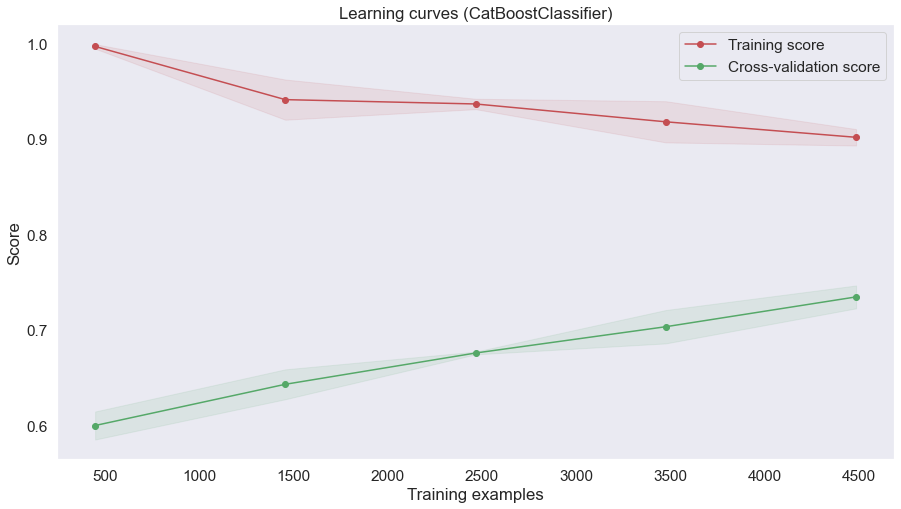

In [328]:
# По графику модель продолжает обучаться на всем объеме выборки, нельзя сказать, что нужно ограничение по размеру выборки
show_learning_curve_plot(model_catb, X_train_balanced_catb, y_train_balanced_catb)

### Финальные модели - Catboost и логистическая регрессия

In [333]:
frozen_params = {
     #'class_weights':[1, disbalance], 
     'silent':True,
     'learning_rate':0.5,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':30,
     'boosting_type':'Ordered'
}

final_catb = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=3)

final_catb.fit(X_train_balanced_catb, y_train_balanced_catb, plot=False, eval_set=(X_test_catb, y_test_catb))
evaluate_preds(model_catb, X_train_balanced_catb, X_test_catb, y_train_balanced_catb, y_test_catb)


    
#Ограничение по числу признаков снижало качество предсказаний [important_features_top]
#final_catb.fit(X_train_balanced_catb[important_features_top], y_train_balanced_catb)
#evaluate_preds(final_catb, 
#               X_train_balanced_catb[important_features_top], 
#               X_test_catb[important_features_top], 
#               y_train_balanced_catb, 
#               y_test_catb)

#params = {
#    'reg_lambda': [0.2, 0.5, 1, 1.3, 1.9, 2.5, 3, 5, 10],
#    'max_depth': [1, 3, 5, 6],
#    'learning_rate': [0.03, 0.1, 0.3, 0.5],
#    'iterations': [100, 200, 300],
#}
#cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#grid_search = GridSearchCV(param_grid=params, estimator=model_catb, cv=cv, verbose=2, scoring='f1')
#grid_search.fit(X_train_balanced_catb, y_train_balanced_catb)
#display(grid_search.best_params_, grid_search.best_score_)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3771
           1       0.76      0.61      0.68      2958

    accuracy                           0.74      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1616
           1       0.52      0.54      0.53       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1304  312
1                294  340


In [334]:
# Взвешенный f1 score был немного выше в Catboost, чем в обычной модели лог. регрессии 
# Но f1 score по предсказанию 1 класса целевой переменной был немного выше в модели лог. регрессии + результаты зависели от random state
final_lr = LogisticRegression()
final_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(final_lr, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      3771
           1       0.71      0.66      0.68      3771

    accuracy                           0.70      7542
   macro avg       0.70      0.70      0.70      7542
weighted avg       0.70      0.70      0.70      7542

TEST

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1616
           1       0.46      0.62      0.53       634

    accuracy                           0.69      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.73      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1157  459
1                239  395


In [304]:
# Применение лучшей модели на тестовом датасете - 
# из двух моделей лучший скор на сабмите показала все равно обычная логистическая регрессия
NUM_FEATURE_NAMES.remove('renewable energy')
df_norm_test = df_fin_test.copy()
df_norm_test[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm_test[NUM_FEATURE_NAMES])

df_fin_test = df_norm_test.copy()

In [306]:
#df_fin_test = df_fin_test.drop(columns = CORRELATED_NAMES)
#признаки для применения модели логистической регрессии к тестовому датасету
CORRELATED_NAMES.remove('renewable energy')
df_fin_test = df_fin_test.drop(columns = CAT_FEATURE_NAMES + CORRELATED_NAMES)
df_fin_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,nan_delinquent,nan_income,opened_loan,nan_jobyears,max_credscore,num_jobyears,IncomeDebtDif,CreditPerc,CoveredCredit,MedLoanByCredHistory,business loan,buy a car,debt consolidation,educational expenses,home improvements,major purchase,moving,other,small business,Home Mortgage,Own Home,Rent
0,-0.192118,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,2.405202,-0.585973,-0.875100,-0.503642,-0.992788,-0.255828,-1.090478,1.968069,-0.367173,-0.188747,-0.261488,-0.572669,-0.026385,-0.378493,-0.240669,-0.795489,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,-0.985702,-0.33185,1.204566
1,-1.332375,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,-0.336726,-0.585973,-1.366071,-0.661931,-1.382250,-0.276284,-1.090478,-0.508112,-0.367173,-0.188747,-0.261488,-1.394996,-1.173800,-0.511022,-0.270638,0.024215,-0.110208,-0.11742,-1.934899,28.850188,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,-0.985702,-0.33185,1.204566
2,-0.211411,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.690524,-0.585973,-0.655151,-0.396341,0.039653,3.917884,0.917029,-0.508112,-0.367173,-0.188747,3.824265,-0.846778,-0.232879,0.176472,-0.203161,0.277820,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
3,-0.128897,-0.091141,0.992538,-0.182805,-0.168202,-0.289398,2.405202,-0.585973,-0.554801,-0.219968,0.804714,-0.250714,-1.090478,-0.508112,-0.367173,-0.188747,-0.261488,1.071986,-0.282523,0.533512,-0.086361,0.527034,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
4,1.235493,-0.091141,-0.038006,0.727138,0.328576,-0.289398,-0.690524,1.706565,2.713121,0.341051,2.108349,-0.271809,0.917029,-0.508112,-0.367173,-0.188747,-0.261488,-0.024451,0.939616,-0.240320,-0.289844,0.527034,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.372715,-0.091141,0.580320,1.485423,-0.100166,1.497011,2.316752,-0.585973,-0.017056,-0.353391,-0.279454,-0.246878,-1.090478,-0.508112,2.723510,-0.188747,-0.261488,1.071986,-0.347660,-0.306810,-0.299864,0.964621,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
2496,-0.192118,-0.091141,0.786429,-0.182805,0.679515,-0.289398,2.714774,-0.585973,0.910028,3.021663,1.275793,-0.255828,-1.090478,1.968069,-0.367173,-0.188747,-0.261488,-1.120887,-0.434849,-0.072209,0.894750,0.527034,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
2497,-0.187955,-0.091141,7.588024,-0.761859,0.658776,-0.289398,-0.690524,-0.585973,0.688282,1.004799,1.615088,-0.278841,0.917029,-0.508112,-0.367173,-0.188747,-0.261488,-1.120887,-0.491494,0.092425,0.190693,-0.063140,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,1.014505,-0.33185,-0.830174
2498,-0.733747,-0.091141,0.580320,1.444062,0.155595,-0.289398,-0.690524,-0.585973,-0.319197,0.250779,-0.412885,-0.247517,0.917029,-0.508112,-0.367173,-0.188747,-0.261488,1.071986,-0.709137,-0.266046,0.165591,0.964621,-0.110208,-0.11742,0.516823,-0.034662,-0.243561,-0.060108,-0.020004,-0.325875,-0.044766,-0.985702,-0.33185,1.204566


In [307]:
#preds = final_catb.predict(df_fin_test)
preds = final_lr.predict(df_fin_test)
preds

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [308]:
submit = pd.read_csv('./data/course_project/sample_submission.csv')
submit['Credit Default'] = preds
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0


In [309]:
submit.to_csv('./data/course_project/morozova_submit.csv', index=False)

In [310]:
df_submitted = pd.read_csv('./data/course_project/morozova_submit.csv')

In [311]:
df_submitted

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0
